In [175]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [176]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [183]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [178]:
data

,avg_gas_price,max_gas_price,min_gas_price
block_timestamp,,,
2021-11-26 00:00:00,97.116698,387.258565,83.061897
2021-11-26 00:05:00,109.238940,1392.976500,95.283713
2021-11-26 00:10:00,103.359952,512.782412,91.935674
2021-11-26 00:15:00,104.216456,371.040167,90.375757
2021-11-26 00:20:00,112.696873,366.088800,101.004660
...,...,...,...
2022-01-26 23:35:00,231.211652,715.003565,217.331739
2022-01-26 23:40:00,192.766040,564.049960,175.238440
2022-01-26 23:45:00,198.883000,501.952909,183.952091


In [180]:
data

,avg_gas_price,max_gas_price,min_gas_price
block_timestamp,,,
2021-11-26 00:00:00,97.116698,387.258565,83.061897
2021-11-26 00:05:00,109.238940,1392.976500,95.283713
2021-11-26 00:10:00,103.359952,512.782412,91.935674
2021-11-26 00:15:00,104.216456,371.040167,90.375757
2021-11-26 00:20:00,112.696873,366.088800,101.004660
...,...,...,...
2022-01-26 23:35:00,231.211652,715.003565,217.331739
2022-01-26 23:40:00,192.766040,564.049960,175.238440
2022-01-26 23:45:00,198.883000,501.952909,183.952091


In [184]:
#Load data as float, datetime to index
data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)
data['block_timestamp'] = pd.to_datetime(data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
data = data.set_index('block_timestamp')
data = data.squeeze()
data = data.astype('float')

#Resample with left edge label i.e min 1-5 mean labelled as min1
data = data.resample(resample_rate).mean()
data
#Convert to gwei
data = data.apply(lambda x: x/1000000000)
data =data[inputs]

#Filter inputs
data =data[inputs]
scaler = MinMaxScaler()
data[inputs] = scaler.fit_transform(data[inputs])
    

#Creat input:output examples
data = data[start_date:end_date].to_numpy()
X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
y = y[:, :, :1]
X_train, X_val = np.split(X, [int(0.7 * len(X))])
#we are only lookign to forecast the min gas price
y_train, y_val = np.split(y, [int(0.7 * len(X))])



In [185]:
#Reshape to 3D for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))

In [186]:
# define model
model = Sequential()
model.add(LSTM(1024, activation='tanh', input_shape=(n_steps_in, len(inputs))))
model.add(Dense(n_steps_out))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [100]:
model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
152/152 [==============================] - 73s 434ms/step - loss: 7.7120e-04
Epoch 2/10
152/152 [==============================] - 70s 464ms/step - loss: 5.3751e-04
Epoch 3/10
152/152 [==============================] - 71s 469ms/step - loss: 4.8811e-04
Epoch 4/10
152/152 [==============================] - 70s 462ms/step - loss: 5.1113e-04
Epoch 5/10
152/152 [==============================] - 68s 447ms/step - loss: 4.7198e-04
Epoch 6/10
152/152 [==============================] - 67s 438ms/step - loss: 4.8327e-04
Epoch 7/10
152/152 [==============================] - 68s 445ms/step - loss: 5.3664e-04
Epoch 8/10
152/152 [==============================] - 74s 487ms/step - loss: 4.9673e-04
Epoch 9/10
152/152 [==============================] - 78s 511ms/step - loss: 4.8329e-04
Epoch 10/10
152/152 [==============================] - 74s 488ms/step - loss: 5.0394e-04


In [10]:
model.save('Multivariate_1block_outliers')


INFO:tensorflow:Assets written to: testLSTM4\assets


INFO:tensorflow:Assets written to: testLSTM4\assets


In [101]:
yhat = model.predict(X_val, verbose=1)

65/65 [==============================] - 17s 246ms/step


In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [45]:
def invert_minxmax (data):
    de_scaled = ((data)*(upper-lower))+lower
    return de_scaled

In [44]:
upper

232.54332709444355

RMSE 14.974908495645481
MAE 9.719908560535062
MAPE 0.1423157855377861


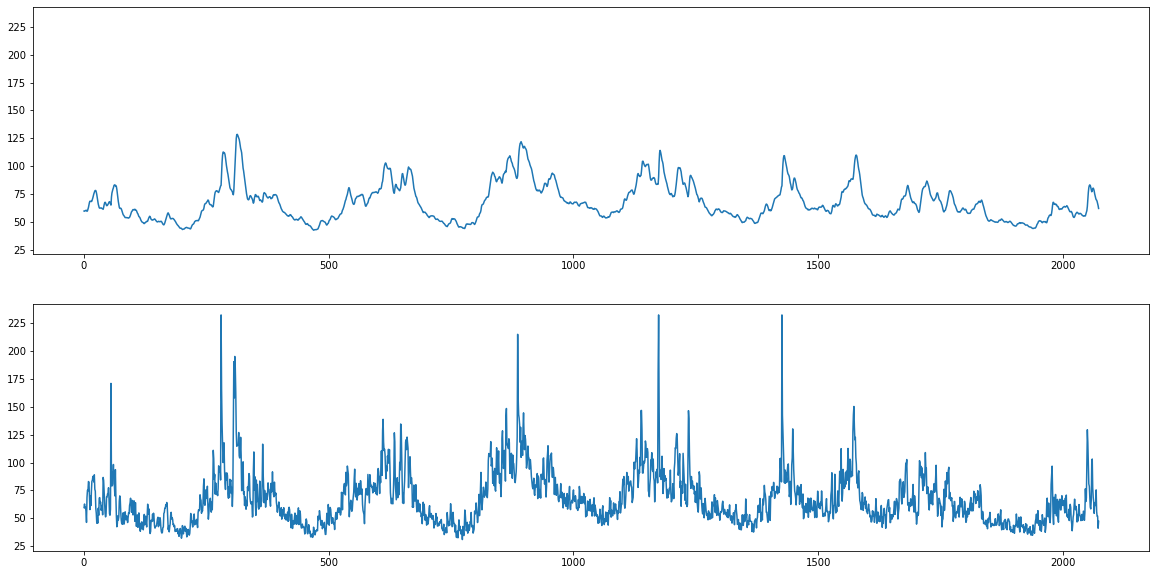

In [58]:
pred_descaled= invert_minxmax(yhat.flatten())
groud_truth_descaled = invert_minxmax(y_val.flatten())


f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(10)
ax1.plot(pred_descaled)
ax2.plot(groud_truth_descaled)



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))

## Lets try without limiting outliers


In [66]:
from sklearn.preprocessing import MinMaxScaler

In [153]:
from sklearn.metrics import r2_score

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
yhat = model.predict(X_val, verbose=1)




65/65 [==============================] - 14s 214ms/step


ValueError: non-broadcastable output operand with shape (2074,1) doesn't match the broadcast shape (2074,2)

RMSE 13.835355637007595
MAE 8.622553000498353
MAPE 0.1318185815583612
R^2 0.675545911988098


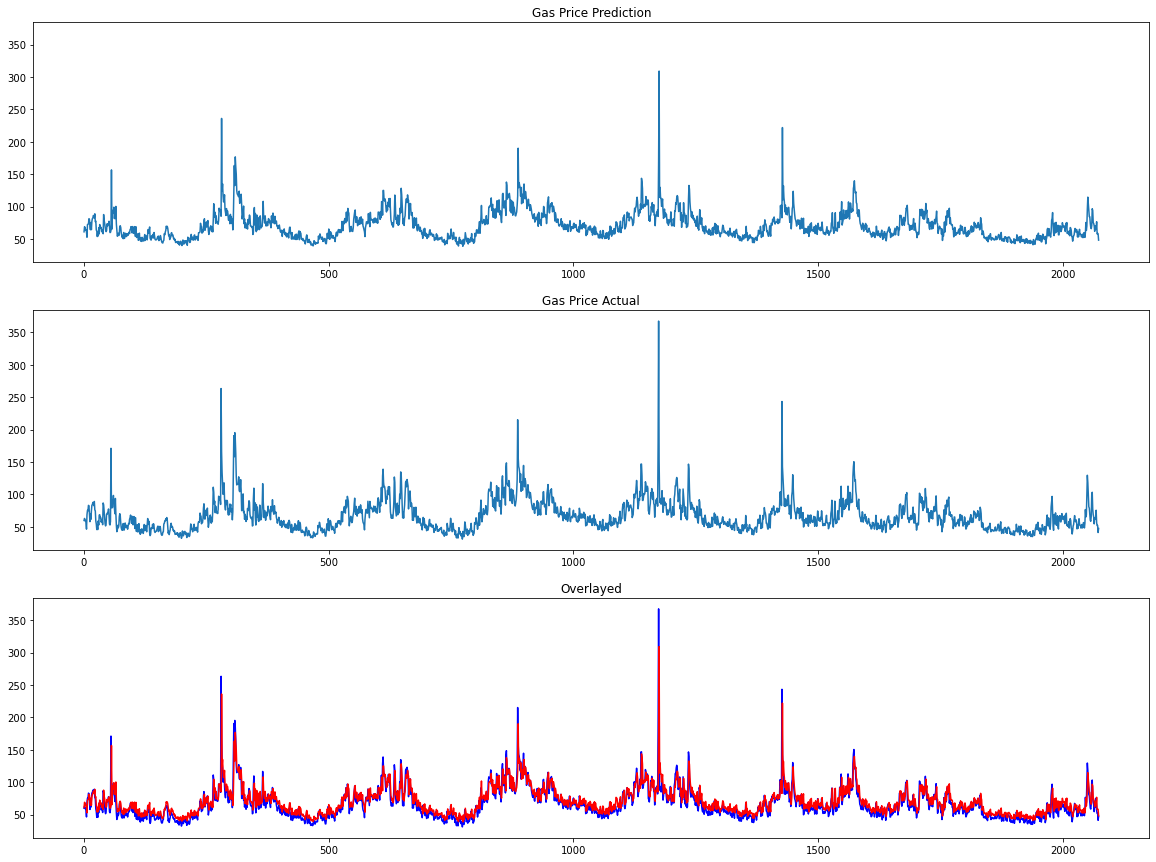

In [161]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler.inverse_transform(array([yhat,]*2).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*2).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets add the 24 hour lag for ming as price

In [188]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr lag']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1

In [189]:
#Load data as float, datetime to index
data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)
data['block_timestamp'] = pd.to_datetime(data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
data = data.set_index('block_timestamp')
data = data.squeeze()
data = data.astype('float')

#Resample with left edge label i.e min 1-5 mean labelled as min1
data = data.resample(resample_rate).mean()

#Add 24hr lag for min gas price
data['min_gas_price_24hr lag'] = data['min_gas_price'].shift(288)
data = data[288:]

#Convert to gwei
data = data.apply(lambda x: x/1000000000)
data =data[inputs]

#Filter inputs
data =data[inputs]
scaler = MinMaxScaler()
data[inputs] = scaler.fit_transform(data[inputs])
    

#Creat input:output examples
data = data[start_date:end_date].to_numpy()
X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
y = y[:, :, :1]
X_train, X_val = np.split(X, [int(0.7 * len(X))])
#we are only lookign to forecast the min gas price
y_train, y_val = np.split(y, [int(0.7 * len(X))])



In [190]:
#Reshape to 3D for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))

In [191]:
# define model
model = Sequential()
model.add(LSTM(1024, activation='tanh', input_shape=(n_steps_in, len(inputs))))
model.add(Dense(n_steps_out))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [192]:
model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
145/145 [==============================] - 67s 443ms/step - loss: 9.3935e-04
Epoch 2/10
145/145 [==============================] - 68s 472ms/step - loss: 6.6115e-04
Epoch 3/10
145/145 [==============================] - 64s 438ms/step - loss: 5.9471e-04
Epoch 4/10
145/145 [==============================] - 67s 463ms/step - loss: 5.0639e-04
Epoch 5/10
145/145 [==============================] - 65s 448ms/step - loss: 4.9685e-04
Epoch 6/10
145/145 [==============================] - 64s 444ms/step - loss: 4.9083e-04
Epoch 7/10
145/145 [==============================] - 64s 440ms/step - loss: 4.8782e-04
Epoch 8/10
145/145 [==============================] - 65s 446ms/step - loss: 4.8792e-04
Epoch 9/10
145/145 [==============================] - 65s 446ms/step - loss: 4.9975e-04
Epoch 10/10
145/145 [==============================] - 63s 436ms/step - loss: 4.7601e-04


In [193]:
yhat = model.predict(X_val, verbose=1)

63/63 [==============================] - 14s 213ms/step


RMSE 13.6956933808414
MAE 8.201963815378436
MAPE 0.1205614220484454
R^2 0.6882093090869688


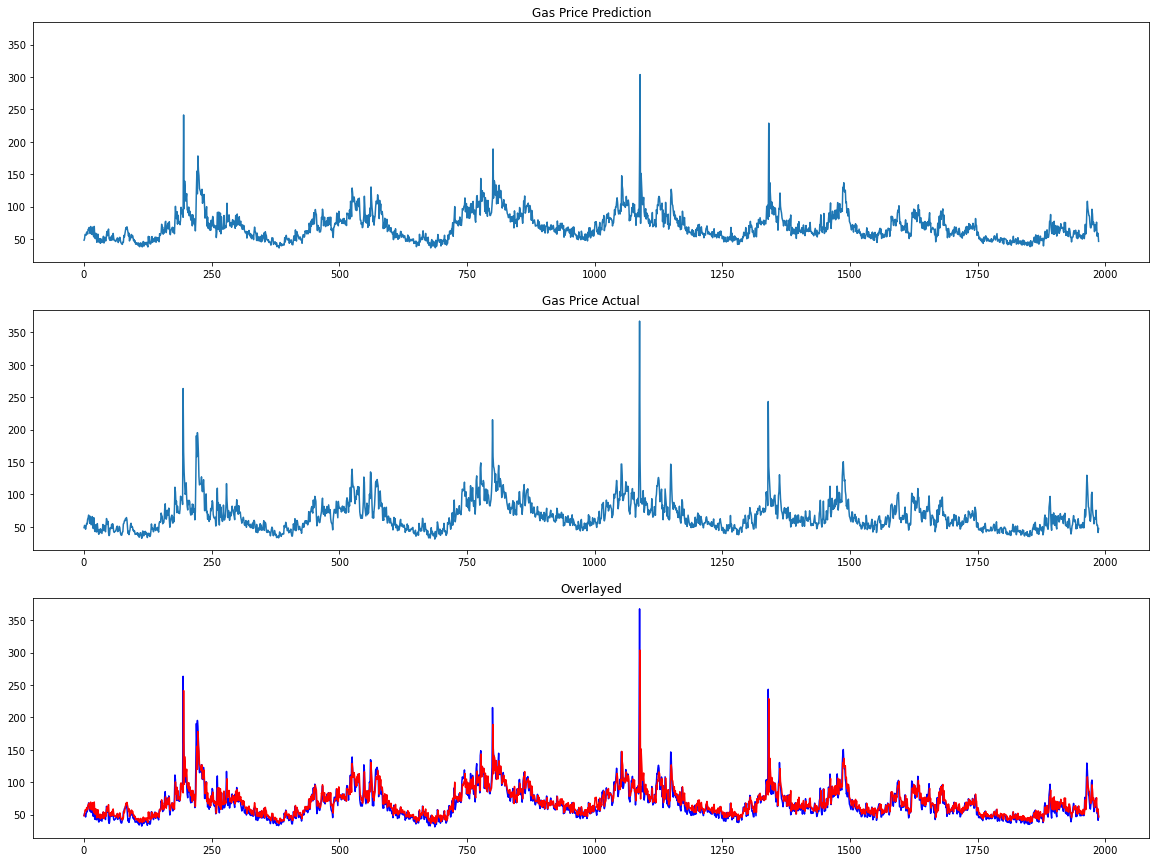

In [201]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[ :, :1]
groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

In [199]:
pred_descaled= (scaler.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))